In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm
from collections import OrderedDict, Counter
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown, display

# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

Reimplementing the vocabulary, data, generator and other methods to use pytorch RNN

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [3]:
min_freq = 5
tokenizer = get_tokenizer("basic_english", language="en")

tokens = []
unk_token = "<unk>"
pad_token = "<pad>"
for text in tqdm(train_df['text'], total=len(train_df)):
    tokens += tokenizer(text)
vocabulary = vocab(OrderedDict(sorted(Counter(tokens).items(), key=lambda x: x[1], reverse=True)), min_freq=min_freq, specials=[pad_token, unk_token])
vocabulary.set_default_index(vocabulary[unk_token])

  0%|          | 0/20000 [00:00<?, ?it/s]

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Here the generator pads to the left, the reason being described in the first notebook

In [5]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    n_samples = len(X)
    n_batches = n_samples // batch_size
    for i in range(n_batches):
        X_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        max_len = max([len(x) for x in X_batch])
        X_batch = torch.stack(
            [torch.cat((torch.tensor([pad_id] * (max_len - len(x)), dtype=int), x)) for x in X_batch],
        )
        yield X_batch, torch.tensor(y_batch, dtype=torch.int)

train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [7]:
# compute accuracy
def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    """
    Compute the accuracy of a model.
    Args:
        y_pred: the predictions of the model.
        y_true: the true labels.
    Returns:
        The accuracy of the model.
    """
    with torch.no_grad():
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        return (y_pred == y_true).sum().item() / len(y_true)

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [8]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [9]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    return_train_loss = []
    return_valid_loss = []
    best_model = None
    best_valid_loss = np.inf

    for epochs in range(n_epochs):
        model.train()
        train_loss_l = []
        train_acc_l = []
        for X_batch, y_batch in tqdm(train_gen()):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze().float(), y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss_l.append(loss.item())
            train_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
        train_loss = np.mean(train_loss_l)
        train_acc = np.mean(train_acc_l)

        print(f"Epoch {epochs}/{n_epochs}")
        print(f"Train loss: {train_loss:.2E}, Train acc: {train_acc}")

        model.eval()
        valid_loss_l = []
        valid_acc_l = []
        with torch.no_grad():
            for X_batch, y_batch in tqdm(valid_gen()):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze().float(), y_batch.float())
                valid_loss_l.append(loss.item())
                valid_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
            valid_loss = np.mean(valid_loss_l)
            valid_acc = np.mean(valid_acc_l)

        print(f"Valid loss: {valid_loss:.2E}, Valid acc: {valid_acc}")

        return_train_loss.append(train_loss)
        return_valid_loss.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
        
    return best_model, return_train_loss, return_valid_loss

In [10]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

0it [00:00, ?it/s]

Epoch 0/20
Train loss: 6.78E-01, Train acc: 0.564


0it [00:00, ?it/s]

Valid loss: 6.74E-01, Valid acc: 0.5643028846153846


0it [00:00, ?it/s]

Epoch 1/20
Train loss: 6.44E-01, Train acc: 0.6185


0it [00:00, ?it/s]

Valid loss: 6.21E-01, Valid acc: 0.6618589743589743


0it [00:00, ?it/s]

Epoch 2/20
Train loss: 5.86E-01, Train acc: 0.6948


0it [00:00, ?it/s]

Valid loss: 5.98E-01, Valid acc: 0.6810897435897436


0it [00:00, ?it/s]

Epoch 3/20
Train loss: 5.58E-01, Train acc: 0.71375


0it [00:00, ?it/s]

Valid loss: 5.95E-01, Valid acc: 0.6854967948717948


0it [00:00, ?it/s]

Epoch 4/20
Train loss: 4.95E-01, Train acc: 0.7693


0it [00:00, ?it/s]

Valid loss: 5.76E-01, Valid acc: 0.727363782051282


0it [00:00, ?it/s]

Epoch 5/20
Train loss: 5.42E-01, Train acc: 0.71955


0it [00:00, ?it/s]

Valid loss: 6.68E-01, Valid acc: 0.5719150641025641


0it [00:00, ?it/s]

Epoch 6/20
Train loss: 6.08E-01, Train acc: 0.6617


0it [00:00, ?it/s]

Valid loss: 6.12E-01, Valid acc: 0.6486378205128205


0it [00:00, ?it/s]

Epoch 7/20
Train loss: 5.35E-01, Train acc: 0.73295


0it [00:00, ?it/s]

Valid loss: 5.98E-01, Valid acc: 0.7049278846153846


0it [00:00, ?it/s]

Epoch 8/20
Train loss: 5.54E-01, Train acc: 0.7117


0it [00:00, ?it/s]

Valid loss: 6.49E-01, Valid acc: 0.6254006410256411


0it [00:00, ?it/s]

Epoch 9/20
Train loss: 5.43E-01, Train acc: 0.71975


0it [00:00, ?it/s]

Valid loss: 6.28E-01, Valid acc: 0.688301282051282


0it [00:00, ?it/s]

Epoch 10/20
Train loss: 4.57E-01, Train acc: 0.78745


0it [00:00, ?it/s]

Valid loss: 5.97E-01, Valid acc: 0.7221554487179487


0it [00:00, ?it/s]

Epoch 11/20
Train loss: 4.02E-01, Train acc: 0.82485


0it [00:00, ?it/s]

Valid loss: 5.75E-01, Valid acc: 0.7045272435897436


0it [00:00, ?it/s]

Epoch 12/20
Train loss: 4.07E-01, Train acc: 0.8192


0it [00:00, ?it/s]

Valid loss: 5.87E-01, Valid acc: 0.7337740384615384


0it [00:00, ?it/s]

Epoch 13/20
Train loss: 3.42E-01, Train acc: 0.8597


0it [00:00, ?it/s]

Valid loss: 5.97E-01, Valid acc: 0.7407852564102564


0it [00:00, ?it/s]

Epoch 14/20
Train loss: 3.13E-01, Train acc: 0.87455


0it [00:00, ?it/s]

Valid loss: 6.00E-01, Valid acc: 0.7526041666666666


0it [00:00, ?it/s]

Epoch 15/20
Train loss: 2.85E-01, Train acc: 0.8891


0it [00:00, ?it/s]

Valid loss: 6.15E-01, Valid acc: 0.7544070512820513


0it [00:00, ?it/s]

Epoch 16/20
Train loss: 2.73E-01, Train acc: 0.89445


0it [00:00, ?it/s]

Valid loss: 6.33E-01, Valid acc: 0.7481971153846154


0it [00:00, ?it/s]

Epoch 17/20
Train loss: 2.75E-01, Train acc: 0.89195


0it [00:00, ?it/s]

Valid loss: 6.64E-01, Valid acc: 0.7618189102564102


0it [00:00, ?it/s]

Epoch 18/20
Train loss: 2.38E-01, Train acc: 0.91195


0it [00:00, ?it/s]

Valid loss: 6.95E-01, Valid acc: 0.7704326923076923


0it [00:00, ?it/s]

Epoch 19/20
Train loss: 2.20E-01, Train acc: 0.92015


0it [00:00, ?it/s]

Valid loss: 7.16E-01, Valid acc: 0.7534054487179487


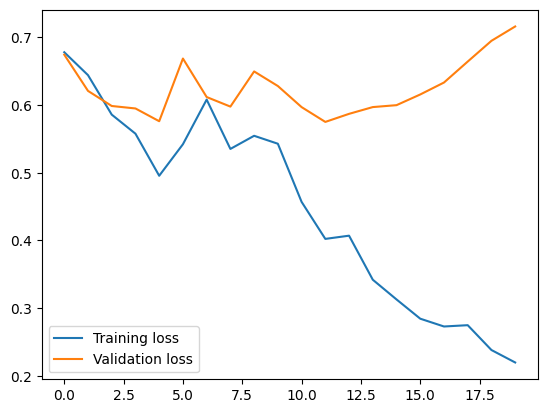

In [12]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** (1) Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** (2) Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** (3) Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** (4) Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** (5) With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** (6) Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

(1) Accuracy function reporting the accuracy of training, validation and test set

In [13]:
# print the test, train and validation accuracy
def acc_func(model: nn.Module, test_gen: Callable) -> float:
    """Test a model.
    Args:
        model: a class inheriting from nn.Module.
        test_gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    test_acc_l = []
    with torch.no_grad():
        for X_batch, y_batch in test_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            test_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
        test_acc = np.mean(test_acc_l)
    return test_acc

print(f"Test accuracy: {acc_func(best_model, test_gen)}")
print(f"Train accuracy: {acc_func(best_model, train_gen)}")
print(f"Valid accuracy: {acc_func(best_model, valid_gen)}")

Test accuracy: 0.7102272727272727
Train accuracy: 0.8083
Valid accuracy: 0.7045272435897436


(2) Our LSTM Class

In [14]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings."""

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the LSTM's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, (h0, c0))
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [15]:
LSTM_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
LSTM_criterion = nn.BCEWithLogitsLoss()
LSTM_optimizer = torch.optim.Adam(LSTM_model.parameters())

In [16]:
LSTM_best_model, LSTM_train_losses, LSTM_valid_losses = train(LSTM_model, LSTM_criterion, LSTM_optimizer, 20, train_gen, valid_gen)

0it [00:00, ?it/s]

Epoch 0/20
Train loss: 6.58E-01, Train acc: 0.6027


0it [00:00, ?it/s]

Valid loss: 6.11E-01, Valid acc: 0.6678685897435898


0it [00:00, ?it/s]

Epoch 1/20
Train loss: 6.20E-01, Train acc: 0.6628


0it [00:00, ?it/s]

Valid loss: 6.88E-01, Valid acc: 0.5208333333333334


0it [00:00, ?it/s]

Epoch 2/20
Train loss: 5.50E-01, Train acc: 0.7264


0it [00:00, ?it/s]

Valid loss: 4.48E-01, Valid acc: 0.8034855769230769


0it [00:00, ?it/s]

Epoch 3/20
Train loss: 3.67E-01, Train acc: 0.84705


0it [00:00, ?it/s]

Valid loss: 3.71E-01, Valid acc: 0.8383413461538461


0it [00:00, ?it/s]

Epoch 4/20
Train loss: 2.73E-01, Train acc: 0.89315


0it [00:00, ?it/s]

Valid loss: 3.37E-01, Valid acc: 0.8605769230769231


0it [00:00, ?it/s]

Epoch 5/20
Train loss: 2.16E-01, Train acc: 0.9225


0it [00:00, ?it/s]

Valid loss: 3.74E-01, Valid acc: 0.8505608974358975


0it [00:00, ?it/s]

Epoch 6/20
Train loss: 1.77E-01, Train acc: 0.93865


0it [00:00, ?it/s]

Valid loss: 3.79E-01, Valid acc: 0.8581730769230769


0it [00:00, ?it/s]

Epoch 7/20
Train loss: 1.48E-01, Train acc: 0.9513


0it [00:00, ?it/s]

Valid loss: 3.88E-01, Valid acc: 0.8657852564102564


0it [00:00, ?it/s]

Epoch 8/20
Train loss: 1.23E-01, Train acc: 0.96145


0it [00:00, ?it/s]

Valid loss: 4.23E-01, Valid acc: 0.8653846153846154


0it [00:00, ?it/s]

Epoch 9/20
Train loss: 1.06E-01, Train acc: 0.96635


0it [00:00, ?it/s]

Valid loss: 4.10E-01, Valid acc: 0.8641826923076923


0it [00:00, ?it/s]

Epoch 10/20
Train loss: 8.71E-02, Train acc: 0.97405


0it [00:00, ?it/s]

Valid loss: 3.64E-01, Valid acc: 0.8790064102564102


0it [00:00, ?it/s]

Epoch 11/20
Train loss: 6.87E-02, Train acc: 0.98105


0it [00:00, ?it/s]

Valid loss: 4.42E-01, Valid acc: 0.8675881410256411


0it [00:00, ?it/s]

Epoch 12/20
Train loss: 5.49E-02, Train acc: 0.98615


0it [00:00, ?it/s]

Valid loss: 4.53E-01, Valid acc: 0.8788060897435898


0it [00:00, ?it/s]

Epoch 13/20
Train loss: 4.50E-02, Train acc: 0.98965


0it [00:00, ?it/s]

Valid loss: 4.79E-01, Valid acc: 0.8774038461538461


0it [00:00, ?it/s]

Epoch 14/20
Train loss: 3.53E-02, Train acc: 0.9924


0it [00:00, ?it/s]

Valid loss: 5.03E-01, Valid acc: 0.8770032051282052


0it [00:00, ?it/s]

Epoch 15/20
Train loss: 2.94E-02, Train acc: 0.994


0it [00:00, ?it/s]

Valid loss: 5.27E-01, Valid acc: 0.8784054487179487


0it [00:00, ?it/s]

Epoch 16/20
Train loss: 4.17E-02, Train acc: 0.9881


0it [00:00, ?it/s]

Valid loss: 5.38E-01, Valid acc: 0.8725961538461539


0it [00:00, ?it/s]

Epoch 17/20
Train loss: 2.28E-02, Train acc: 0.9949


0it [00:00, ?it/s]

Valid loss: 5.60E-01, Valid acc: 0.882011217948718


0it [00:00, ?it/s]

Epoch 18/20
Train loss: 1.69E-02, Train acc: 0.99655


0it [00:00, ?it/s]

Valid loss: 6.25E-01, Valid acc: 0.8802083333333334


0it [00:00, ?it/s]

Epoch 19/20
Train loss: 1.36E-02, Train acc: 0.99725


0it [00:00, ?it/s]

Valid loss: 6.67E-01, Valid acc: 0.8782051282051282


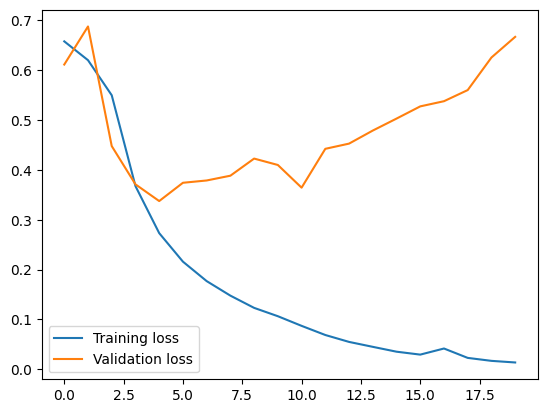

In [17]:
plt.plot(LSTM_train_losses, label="Training loss")
plt.plot(LSTM_valid_losses, label="Validation loss")
plt.legend()
plt.show()

In [18]:
print(f"Test accuracy: {acc_func(LSTM_best_model, test_gen)}")
print(f"Train accuracy: {acc_func(LSTM_best_model, train_gen)}")
print(f"Valid accuracy: {acc_func(LSTM_best_model, valid_gen)}")

Test accuracy: 0.857634443021767
Train accuracy: 0.91585
Valid accuracy: 0.8605769230769231


Comparing results between RNN and LSTM :

In [19]:
print(f"RNN Test accuracy: {acc_func(best_model, test_gen)}")
print(f"LSTM Test accuracy: {acc_func(LSTM_best_model, test_gen)}")
print("")

print(f"RNN Train accuracy: {acc_func(best_model, train_gen)}")
print(f"LSTM Train accuracy: {acc_func(LSTM_best_model, train_gen)}")
print("")

print(f"RNN Valid accuracy: {acc_func(best_model, valid_gen)}")
print(f"LSTM Valid accuracy: {acc_func(LSTM_best_model, valid_gen)}")

RNN Test accuracy: 0.7102272727272727
LSTM Test accuracy: 0.857634443021767

RNN Train accuracy: 0.8083
LSTM Train accuracy: 0.91585

RNN Valid accuracy: 0.7045272435897436
LSTM Valid accuracy: 0.8605769230769231


Both models seems to overfit the data, LSTM does a way stronger overfit after a lot of epochs.

But overall LSTM has a better validation accuracy on it's best model than RNN.

(3) Creating the function to predit from text :

In [20]:
def predict(text, model):
    model.eval()
    with torch.no_grad():
        text = text_pipeline(text).unsqueeze(0).to(device)
        y_pred = model(text)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        return y_pred.item()

Testing the predict functions

In [21]:
str = "This movie is bad"
print("RNN : ", str , predict(str, best_model))
print("LSTM : ", str , predict(str, LSTM_best_model))

str = "This movie is good"
print("RNN : ", str , predict(str, best_model))
print("LSTM : ", str , predict(str, LSTM_best_model))

str = "This movie is not bad"
print("RNN : ", str , predict(str, best_model))
print("LSTM : ", str , predict(str, LSTM_best_model))

RNN :  This movie is bad 0.0
LSTM :  This movie is bad 0.0
RNN :  This movie is good 1.0
LSTM :  This movie is good 0.0
RNN :  This movie is not bad 0.0
LSTM :  This movie is not bad 0.0


(5) Looking on LSTM at 2 wrong predictions with method :

In [22]:
def print_wrong_prediction(model, nb=2):
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            y_pred = torch.sigmoid(y_pred)
            y_pred = torch.round(y_pred)
            for i in range(len(y_pred)):
                if y_pred[i] != y_batch[i]:
                    print("Predicted : ", y_pred[i].item(), "Actual : ", y_batch[i].item())
                    print("Text : ")
                    display(Markdown(test_df["text"][i]))
                    nb -= 1
                    if nb == 0:
                        return

print_wrong_prediction(best_model)

Predicted :  1.0 Actual :  0
Text : 


First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!

Predicted :  1.0 Actual :  0
Text : 


I had high hopes for this one until they changed the name to 'The Shepherd : Border Patrol, the lamest movie name ever, what was wrong with just 'The Shepherd'. This is a by the numbers action flick that tips its hat at many classic Van Damme films. There is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame. There is one great line about 'being p*ss drunk and carrying a rabbit' and some OK action scenes let down by the cheapness of it all. A lot of the times the dialogue doesn't match the characters mouth and the stunt men fall down dead a split second before even being shot. The end fight is one of the better Van Damme fights except the Director tries to go a bit too John Woo and fails also introducing flashbacks which no one really cares about just gets in the way of the action which is the whole point of a van Damme film.<br /><br />Not good, not bad, just average generic action.

For the first prediction we think the movie may have a bad label because we see this review as a mid/positive one although it's labelled 0.

For the second one the review is extremely mitigated because it concludes by saying the film is average but not bad. This review is really difficult to evaluate.